In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8223856151315463949
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4133486592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9496422590008071741
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:26:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# -------------------------------------
# 2. CONFIGURACIÓN
# -------------------------------------

In [14]:
tf.keras.mixed_precision.set_global_policy('float32')
#mixed_precision.set_global_policy('mixed_float16')

# Parámetros
img_size = (224, 224)
batch_size = 32
epochs = 100
seed = 123
train_dir = '../dataset/multi-6/train'
model_path = 'efficientnetb0_v2.keras'

# -------------------------------------
# 3. DATA AUGMENTATION Y GENERADORES
# -------------------------------------

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)
# Obtener número de clases
class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases:", class_names)

#Imprimir dataset
for x, y in train_ds.take(5):
    print("Imagen shape:", x.shape)
    print("Etiqueta:", y.numpy())


Found 30901 files belonging to 6 classes.
Using 24721 files for training.
Found 30901 files belonging to 6 classes.
Using 6180 files for validation.
Clases: ['Acne', 'Benign', 'Eczema', 'Infectious', 'Malign', 'Pigmentation']
Imagen shape: (32, 224, 224, 3)
Etiqueta: [0 1 3 1 1 3 0 4 2 2 1 3 1 1 5 1 3 4 1 1 1 3 1 1 1 1 2 1 2 3 1 0]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [0 1 5 1 1 1 4 3 1 0 3 1 4 1 3 4 4 1 2 1 5 4 4 4 3 1 2 0 4 1 1 4]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [1 0 0 4 1 3 1 4 1 3 3 4 5 4 3 4 2 4 1 4 3 4 4 1 4 4 1 3 3 3 1 1]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [1 3 1 1 1 1 1 1 4 0 3 4 1 2 3 1 1 5 2 1 4 2 3 3 4 4 2 2 1 1 1 2]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [2 4 1 1 2 3 3 3 4 3 1 0 1 1 3 5 3 5 2 4 2 1 3 1 1 0 0 4 3 4 1 0]


In [6]:

# ---------------------------------------
# CÁLCULO DE PESOS POR CLASE
# ---------------------------------------
from sklearn.utils.class_weight import compute_class_weight

# Contar imágenes por clase
image_counts = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    count = len(os.listdir(class_path))
    image_counts.append(count)

# Crear vector de etiquetas reales
y_train = []
for i, count in enumerate(image_counts):
    y_train += [i] * count
y_train = np.array(y_train)

# Calcular pesos
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(weights))

print("Pesos por clase:", class_weight)

Pesos por clase: {0: 2.396618582286335, 1: 0.4733762254901961, 2: 1.2654381654381655, 3: 0.8583888888888889, 4: 0.7593002113125952, 5: 5.049346405228758}


In [7]:
# ----------------------------
# PENALIZACIÓN EN CLASES CON MAYOR RIESGO
# ----------------------------

high_danger = {4}

moderate_danger = {2, 3}

low_danger = set(range(num_classes)) - high_danger - moderate_danger

cost_matrix = tf.ones([num_classes, num_classes])           # baseline cost = 1

cost_matrix = tf.where(tf.eye(num_classes) == 1, 0., cost_matrix)     # zero on the diagonal

# Penalizes False Negatives for the high and moderate danger

for high in high_danger:
    for low in low_danger:
        cost_matrix = tf.tensor_scatter_nd_update(cost_matrix,
                                        indices=[[high, low]],
                                        updates=[10.0]) 
        
    for mid in moderate_danger:
        cost_matrix = tf.tensor_scatter_nd_update(cost_matrix,
                                        indices=[[high, mid]],
                                        updates=[5.0]) 
        
for mid in moderate_danger:
    for low in low_danger:
        cost_matrix = tf.tensor_scatter_nd_update(cost_matrix,
                                        indices=[[mid, low]],
                                        updates=[5.0])
        
print(cost_matrix)


tf.Tensor(
[[ 0.  1.  1.  1.  1.  1.]
 [ 1.  0.  1.  1.  1.  1.]
 [ 5.  5.  0.  1.  1.  5.]
 [ 5.  5.  1.  0.  1.  5.]
 [10. 10.  5.  5.  0. 10.]
 [ 1.  1.  1.  1.  1.  0.]], shape=(6, 6), dtype=float32)


In [8]:
def cost_matrix_sparse_categorical_crossentropy_loss(y_true, y_pred, alpha=1.0, debug=False):
    if y_true.dtype.is_integer:
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    if y_true.ndim == 1:                      # still a vector? → make it (1,K)
        y_true = tf.expand_dims(y_true, 0)
    # The cost of this prediction, using the row of the matrix
    row_cost = tf.matmul(y_true, cost_matrix) 
    if debug:
        print(row_cost)
    # Sums all the costs, 0s and the cost of the true prediction, multiplied by the 
    exp_cost = tf.reduce_sum(row_cost * y_pred, axis=-1)
    if debug:
        print(exp_cost)

    y_pred = tf.nn.softmax(y_pred)
    cross_entro = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return cross_entro + alpha * exp_cost
    

In [9]:
y_true = tf.convert_to_tensor([[0.,0.,0.,0.,1.,0.]], dtype=tf.float32)
print(y_true.ndim)
y_pred = tf.convert_to_tensor([[0.2,0.2,0.,0.,0.47,0.13]], dtype=tf.float32)
print(y_pred.ndim)
loss = cost_matrix_sparse_categorical_crossentropy_loss(y_true, y_pred, debug=True)
print(loss)


2
2
tf.Tensor([[10. 10.  5.  5.  0. 10.]], shape=(1, 6), dtype=float32)
tf.Tensor([5.3], shape=(1,), dtype=float32)
tf.Tensor([6.801526], shape=(1,), dtype=float32)


In [10]:
# Optimización de rendimiento
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Configuración de caché y prefetch
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
# Modelo base (preentrenado)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # congelamos capas base

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.GaussianNoise(0.2)
])


# Modelo completo (sin preprocessing dentro)
model = models.Sequential([
    base_model,
    data_augmentation,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compilar modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',#
    metrics=['accuracy']
)

In [16]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True)
]

# Entrenamiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weight 
)


Epoch 1/100
773/773 [==============================] - 120s 146ms/step - loss: 0.9325 - accuracy: 0.6269 - val_loss: 0.7622 - val_accuracy: 0.6887
Epoch 2/100
773/773 [==============================] - 106s 137ms/step - loss: 0.7522 - accuracy: 0.7000 - val_loss: 0.6961 - val_accuracy: 0.7278
Epoch 3/100
773/773 [==============================] - 107s 139ms/step - loss: 0.6640 - accuracy: 0.7317 - val_loss: 0.6531 - val_accuracy: 0.7443
Epoch 4/100
773/773 [==============================] - 106s 137ms/step - loss: 0.5947 - accuracy: 0.7526 - val_loss: 0.6091 - val_accuracy: 0.7673
Epoch 5/100
773/773 [==============================] - 122s 158ms/step - loss: 0.5463 - accuracy: 0.7722 - val_loss: 0.5935 - val_accuracy: 0.7752
Epoch 6/100
773/773 [==============================] - 105s 136ms/step - loss: 0.5025 - accuracy: 0.7886 - val_loss: 0.5686 - val_accuracy: 0.7893
Epoch 7/100
773/773 [==============================] - 105s 136ms/step - loss: 0.4579 - accuracy: 0.8073 - val_loss: 0

194/194 [==============================] - 13s 63ms/step

🧾 Clasification Report:

              precision    recall  f1-score   support

        Acne       0.82      0.87      0.84       397
      Benign       0.91      0.86      0.88      2161
      Eczema       0.78      0.87      0.83       831
  Infectious       0.81      0.84      0.83      1238
      Malign       0.83      0.81      0.82      1338
Pigmentation       0.72      0.66      0.69       215

    accuracy                           0.84      6180
   macro avg       0.81      0.82      0.81      6180
weighted avg       0.84      0.84      0.84      6180



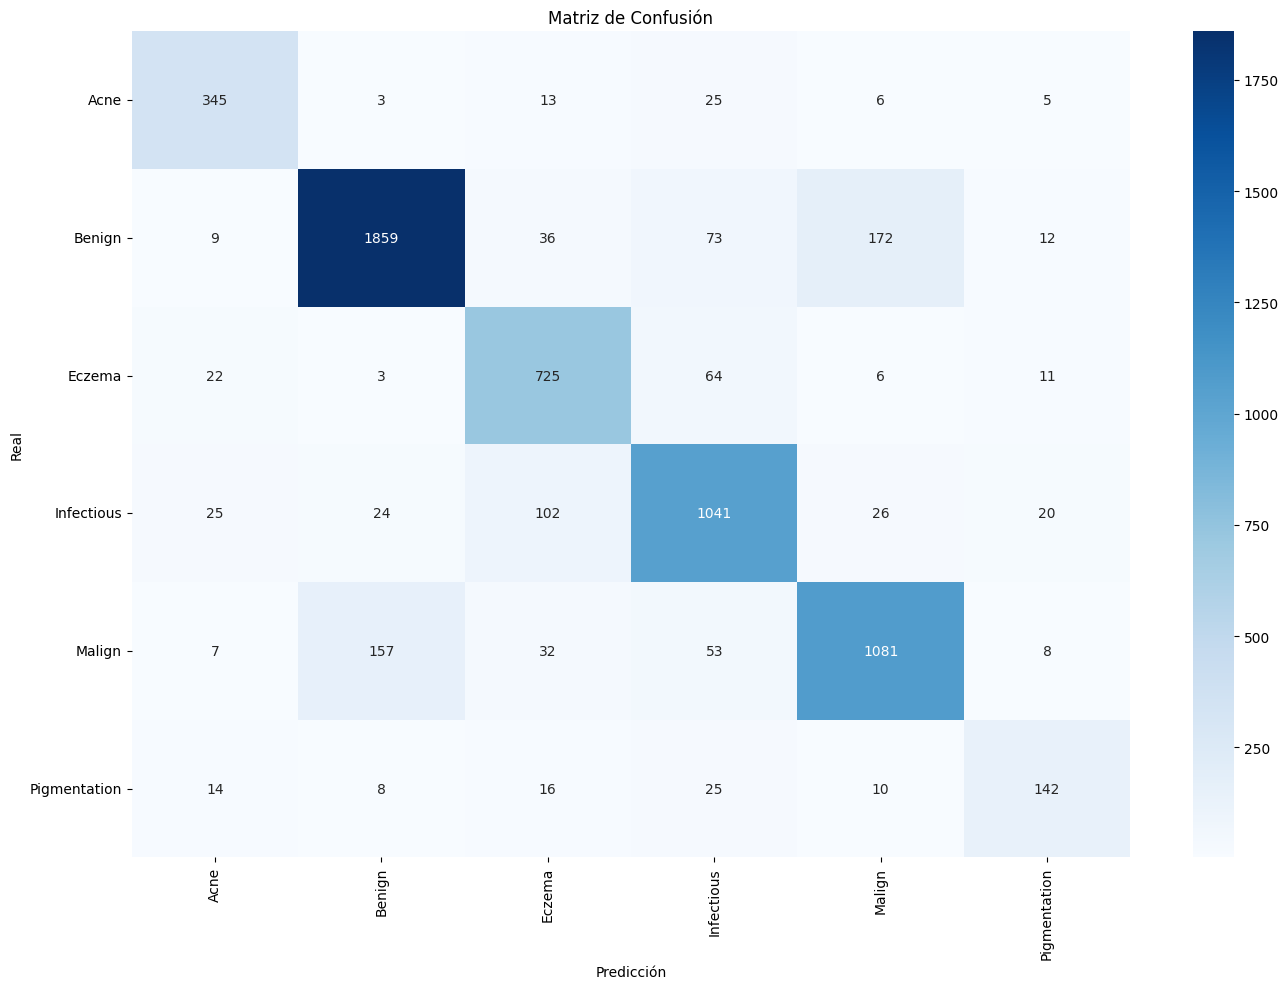

In [17]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
"""
# Rutas
test_dir = '../dataset/multi-6/test'

# Cargar modelo entrenado
model = tf.keras.models.load_model(model_path)

# Cargar dataset de test
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False  # MUY IMPORTANTE para alinear predicciones con etiquetas
)

# Obtener nombres de clase
class_names = test_ds.class_names
num_classes = len(class_names)

# Prefetch para acelerar
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Obtener predicciones
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener etiquetas reales
y_true = np.concatenate([y.numpy() for x, y in test_ds])

# Reporte de clasificación
print("🧾 Clasification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

"""
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y.numpy() for x, y in val_ds])

print("\n🧾 Clasification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()